In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, spearmanr

In [48]:
# Read all data tables
df_slurp = pd.read_csv('data/merged_kf_sr.csv')
df_ido = pd.read_excel('data/idoc-all-new.xlsx', engine='openpyxl')
df_hydro = pd.read_excel('data/hydro-multipacpoints-depth.xlsx', engine='openpyxl', skiprows=[1])
df_ido = df_ido.rename(columns={'meas_station':'sample'})

# Perform the merge on 'sample' and rounded 'depth'
df_slurp_ido = pd.merge(df_slurp, df_ido, on=['sample', 'dp_position'], how='outer', suffixes=('_slurp', '_ido'))
df_slurp_ido['depth_rounded'] = df_slurp_ido['depth_sat_zone_slurp'].round(3).astype(float)
df_hydro['depth_rounded'] = df_hydro['Sediment depth kf'].round(3).astype(float)
df = pd.merge(df_slurp_ido, df_hydro, on=['sample', 'depth_rounded'], how='outer')
df = df.dropna(subset=['delta_T_norm', 'depth_sat_zone_ido'])

C:\Users\Negreiros\AppData\Local\Temp\ipykernel_6172\1289348901.py:8: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_slurp_ido = pd.merge(df_slurp, df_ido, on=['sample', 'dp_position'], how='outer', suffixes=('_slurp', '_ido'))


In [49]:
df['delta_IDO_norm'] = df['delta_IDO_norm'].abs()
df['delta_T_norm'] = df['delta_T_norm'].abs()

In [50]:
# Remove positions 1 (on shore) from dataset
df = df[df['profile_location'] != 3]
df = df[df['profile_location'] != 4]

In [51]:
# Define features and target variable
variables = [
            'depth_sat_zone_ido', 
            'wl',
            'log_kf_equation',
            'slurp_rate_final',
            'delta_IDO_norm',
            'delta_T_norm',
            'd50_x',
            '2',
            #'site',
            'sample'
        	]
equation = 'frings'
df['log_kf_equation'] = np.log10(df['Frings et al. (2011)  [Estimated kf]'])

mapper = {'depth_sat_zone_ido': '$h_z$', 
            'wl': '$d$',
            'log_kf_equation': '$log(k_{f,Kozeny})$',
            'slurp_rate_final': '$s_r$',
            'delta_IDO_norm': '$\Delta DO_{norm}$',
            'delta_T_norm': '$\Delta T_{norm}$',
            'd50_x': '$d_{50}$',
            '2': '$FSF_{<2}$',
            }


C:\lkl\negreiros\Anaconda3\envs\py39_new\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [52]:
df[variables]

,depth_sat_zone_ido,wl,log_kf_equation,slurp_rate_final,delta_IDO_norm,delta_T_norm,d50_x,2,sample
8,0.381167,-0.258833,-4.634512,1.060000,0.894013,0.000000,16.071579,20.401089,A-1
9,0.411167,-0.258833,-4.634512,3.520000,0.911863,0.000000,16.071579,20.401089,A-1
10,0.441167,-0.258833,-4.634512,7.710000,0.982521,0.000000,16.071579,20.401089,A-1
11,0.471167,-0.258833,-4.634512,17.500000,0.971365,0.043825,16.071579,20.401089,A-1
12,0.531167,-0.258833,-4.634512,16.600000,0.982707,0.031873,16.071579,20.401089,A-1
...,...,...,...,...,...,...,...,...,...
290,0.340000,0.070000,-5.209715,2.745000,0.951146,0.060484,0.879073,65.321445,H-2
291,0.400000,0.070000,-5.209715,6.116667,0.980398,0.080645,0.879073,65.321445,H-2
292,0.460000,0.070000,-5.209715,5.470000,0.987937,0.088710,0.879073,65.321445,H-2
293,0.520000,0.070000,-5.209715,23.166667,0.993969,0.108871,0.879073,65.321445,H-2


In [53]:
df = df.dropna(subset=variables)

In [54]:
# Calculate correlation matrix
df_renamed = df[variables].rename(columns=mapper)
df_renamed

,$h_z$,$d$,"$log(k_{f,Kozeny})$",$s_r$,$\Delta DO_{norm}$,$\Delta T_{norm}$,$d_{50}$,$FSF_{<2}$,sample
8,0.381167,-0.258833,-4.634512,1.060000,0.894013,0.000000,16.071579,20.401089,A-1
9,0.411167,-0.258833,-4.634512,3.520000,0.911863,0.000000,16.071579,20.401089,A-1
10,0.441167,-0.258833,-4.634512,7.710000,0.982521,0.000000,16.071579,20.401089,A-1
11,0.471167,-0.258833,-4.634512,17.500000,0.971365,0.043825,16.071579,20.401089,A-1
12,0.531167,-0.258833,-4.634512,16.600000,0.982707,0.031873,16.071579,20.401089,A-1
...,...,...,...,...,...,...,...,...,...
289,0.280000,0.070000,-5.209715,2.015000,0.946019,0.068548,0.879073,65.321445,H-2
290,0.340000,0.070000,-5.209715,2.745000,0.951146,0.060484,0.879073,65.321445,H-2
291,0.400000,0.070000,-5.209715,6.116667,0.980398,0.080645,0.879073,65.321445,H-2
292,0.460000,0.070000,-5.209715,5.470000,0.987937,0.088710,0.879073,65.321445,H-2


In [55]:
grouped_averages = df_renamed.groupby(['sample']).mean().reset_index()
df_2corr_avg = grouped_averages.drop(columns=['sample', '$h_z$'])
corr_matrix = df_2corr_avg.corr(method='spearman')

In [56]:
grouped_averages.shape

(16, 9)

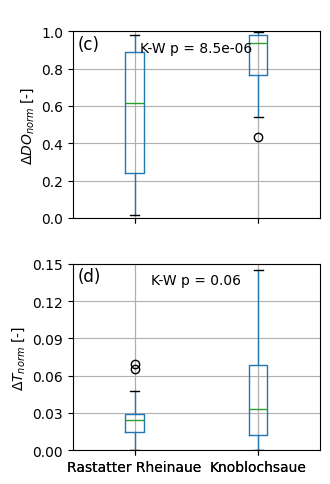

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from matplotlib.ticker import ScalarFormatter

# 1. Rename sites
df['site'] = df['sample'].map({
    'A-1': 'Rastatter Rheinaue',
    'A-2': 'Rastatter Rheinaue',
    'B-1': 'Rastatter Rheinaue',
    'B-2': 'Rastatter Rheinaue',
    'C-1': 'Rastatter Rheinaue',
    'C-2': 'Rastatter Rheinaue',
    'D-1': 'Knoblochsaue',
    'D-2': 'Knoblochsaue',
    'E-1': 'Knoblochsaue',
    'E-2': 'Knoblochsaue',
    'F-1': 'Knoblochsaue',
    'F-2': 'Knoblochsaue',
    'G-1': 'Knoblochsaue',
    'G-2': 'Knoblochsaue',
    'H-1': 'Knoblochsaue',
    'H-2': 'Knoblochsaue'
})

# 2. Declare categorical with the exact order you want
df['site'] = pd.Categorical(
    df['site'],
    categories=['Rastatter Rheinaue', 'Knoblochsaue'],
    ordered=True
)

# 3a. Kruskal–Wallis for ΔDO_norm
rr_do  = df[df['site']=='Rastatter Rheinaue']['delta_IDO_norm']
kn_do  = df[df['site']=='Knoblochsaue']['delta_IDO_norm']
stat_do, p_do = kruskal(rr_do, kn_do)

# 3b. Kruskal–Wallis for |ΔT_norm|
rr_t   = df[df['site']=='Rastatter Rheinaue']['delta_T_norm']
kn_t   = df[df['site']=='Knoblochsaue']['delta_T_norm']
stat_t, p_t = kruskal(rr_t, kn_t)

# 4. Create figure with two subplots
fig, axes = plt.subplots(nrows=2, figsize=(4*0.85, 6*0.85), sharex=True)

# 5. First panel: ΔDO_norm by site
df.boxplot(
    column='delta_IDO_norm',
    by='site',
    grid=False,
    ax=axes[0]
)
axes[0].set_title(' ')
axes[0].set_xlabel('')
axes[0].set_ylabel('$\\Delta DO_{norm}$ [-]')
axes[0].set_ylim(0, 1)
axes[0].text(
    0.5, 0.95,
    f'K-W p = {p_do:.1e}',
    transform=axes[0].transAxes,
    ha='center',
    va='top'
)
axes[0].text(
    0.02, 0.98,
    '(c)',
    transform=axes[0].transAxes,
    ha='left',
    va='top',
    fontsize=12,
    #fontweight='bold'
)
axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].grid(True)

# 6. Second panel: |ΔT_norm| by site
df.boxplot(
    column='delta_T_norm',
    by='site',
    grid=False,
    ax=axes[1]
)
axes[1].set_title(' ')
axes[1].set_xlabel('')
axes[1].set_ylabel('$\\Delta T_{norm}$ [-]')
axes[1].set_ylim(0, 0.15)
axes[1].set_yticks(np.arange(0, 0.16, 0.15/5))
axes[1].text(
    0.5, 0.95,
    f'K-W p = {p_t:.2f}',
    transform=axes[1].transAxes,
    ha='center',
    va='top'
)
axes[1].text(
    0.02, 0.98,
    '(d)',
    transform=axes[1].transAxes,
    ha='left',
    va='top',
    fontsize=12,
    #fontweight='bold'
)
axes[1].yaxis.set_major_formatter(ScalarFormatter())
axes[1].grid(True)

# 7. Final layout, save, show
plt.suptitle('')
plt.tight_layout()
plt.savefig('figs/dissim-metrics-positions1-2.png', dpi=600)
plt.show()

In [58]:
pairwise_params2mask = [
                        ('$log(k_{f,Kozeny})$', '$d_{50}$'),
                        ('$log(k_{f,Kozeny})$', '$FSF_{<2}$'),

                       ]

# Initialize mask to hide upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

for pairwise_param2mask_pair in pairwise_params2mask:
    # find their integer positions
    ii = list(corr_matrix.columns).index(pairwise_param2mask_pair[0])
    jj = list(corr_matrix.columns).index(pairwise_param2mask_pair[1])
    # mask both [i, j] and [j, i]
    mask[ii, jj] = True
    mask[jj, ii] = True

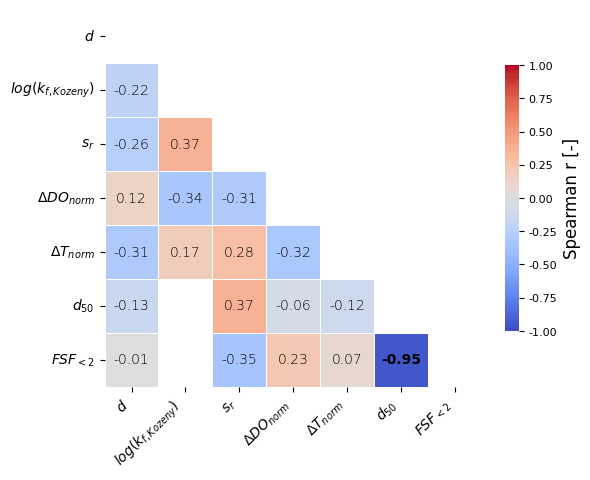

In [59]:
# compute the overall min and max
vmin = corr_matrix.values.min()
vmax = corr_matrix.values.max()

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    mask=mask,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    cbar_kws={
        "shrink": 0.5
    }
)

cbar = ax.collections[0].colorbar
cbar.set_label("Spearman r [-]", fontsize=12)
cbar.ax.tick_params(labelsize=8)

# force ticks at the extremes
ticks = np.arange(1, -1.1, -0.25)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

cols = corr_matrix.columns

pvals = pd.DataFrame(np.ones((len(cols), len(cols))), index=cols, columns=cols)
for i, ci in enumerate(cols):
    for j, cj in enumerate(cols):
        if i < j:
            r, p = spearmanr(df_2corr_avg[ci], df_2corr_avg[cj])
            pvals.iloc[i, j] = pvals.iloc[j, i] = p
            
n = len(cols)
for i in range(n):
    for j in range(n):
        if mask[i, j]:
            continue
        r_val = corr_matrix.iloc[i, j]
        p_val = pvals.iloc[i, j]
        txt = f"{r_val:.2f}"
        weight = 'heavy' if p_val < 0.05 else 'ultralight'
        ax.text(
            j + 0.5,
            i + 0.5,
            txt,
            ha='center',
            va='center',
            fontsize=10,
            fontweight=weight,
            color='black'
        )

ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticklabels(cols, rotation=0)
#ax.set_title("Spearman Correlations\n(bold = p < 0.05)")

plt.tight_layout()
plt.savefig('figs/corr-matrix-positions1-2.png', dpi=400)